In [1]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Activation
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
#print("Cuda version: {}".format(tf_build_info.cuda_version_number))
#print("Cudnn version: {}".format(tf_build_info.cudnn_version_number))
print("Num Physical GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num Logical GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

NETWORK_W = 416
NETWORK_H = 416

TensorFlow version: 2.3.1
Eager execution: True
Keras version: 2.4.0
Num Physical GPUs Available:  0
Num Logical GPUs Available:  0


In [2]:
def route_group(input_layer, groups, group_id):
    convs = tf.split(input_layer, num_or_size_splits=groups, axis=-1)
    return convs[group_id]

In [3]:
def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip: # handle Shorcut -3 
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)
        
        if conv['bnorm']: x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)    
        
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
            
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x

In [4]:
def make_yolov4_model():
        
    input_image = Input(shape=(NETWORK_H, NETWORK_W, 3), name='input_0')

    # ------------------------ begin BACKBONE CSPDARKNET53_TINY -------------------------------------------- #
    ## Layer 0 [convolutional]
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 0}])

    ## Layer 1 [convolutional]
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 1}])
    layer_1 = x
     
    ## Layer 2 [convolutional] 
    x = _conv_block(x, [{'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 2}])
    layer_2 = x
    
    ## Layer 3 [route] layers = -1 Groups = 2 Group ID = 1
    route = x
    x = route_group(x, 2, 1)
    
    ## Layer  4 => 5 [convolutional]
    x = _conv_block(x, [{'filter':  32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 4}])
    layer_4 = x
    x = _conv_block(x, [{'filter':  32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 5}])
    layer_5 = x
    
    ## Layer 6 [route] -1, -2
    x = concatenate([layer_5, layer_4], name='concat_6')
    
    ## Layer 7 [convolutional]
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 7}])
    layer_7 = x
    
    ## Layer 8 [route] -6, -1
    x = concatenate([layer_2, layer_7], name='concat_8')
    
    ## Layer 9 [maxpool]
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'layer_9')(x)
    
    ## Layer 10 [convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 10}])
    layer_10 = x
    
    ## Layer 11 [route] layers = -1 Groups = 2 Group ID = 1
    route = x
    x = route_group(x, 2, 1)
    
    ## Layer  12 => 13 [convolutional]
    x = _conv_block(x, [{'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 12}])
    layer_12 = x
    x = _conv_block(x, [{'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 13}])
    layer_13 = x
    
    ## Layer 14 [route] -1, -2
    x = concatenate([layer_13, layer_12], name='concat_14')
    
    ## Layer 15 [convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 15}])
    layer_15 = x
    
    ## Layer 16 [route] -6, -1
    x = concatenate([layer_10, layer_15], name='concat_16')
    
    ## Layer 17 [maxpool]
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'layer_17')(x)
    
    ## Layer 18 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 18}])
    layer_18 = x
    
    ## Layer 19 [route] layers = -1 Groups = 2 Group ID = 1
    route = x
    x = route_group(x, 2, 1)
    
    ## Layer  20 => 21 [convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 20}])
    layer_20 = x
    x = _conv_block(x, [{'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 21}])
    layer_21 = x
    
    ## Layer 22 [route] -1, -2
    x = concatenate([layer_21, layer_20], name='concat_22')
    
    ## Layer 23 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 23}])
    layer_23 = x
    
    ## Layer 24 [route] -6, -1
    x = concatenate([layer_18, layer_23], name='concat_24')
    
    ## Layer 25 [maxpool]
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'layer_25')(x)
    
    ## Layer 26 [convolutional]
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 26}])
    layer_26 = x
    
    
    # -------------------------- end BACKBONE CSPDARKNET53_TINY -------------------------------------------- #
    
    ## Layer 27 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 27}])
    layer_27 = x
    
    ## Layer 28 [convolutional]
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 28}])
    layer_28 = x
    
    ## Layer 29 [convolutional]
    x = _conv_block(x, [{'filter':  18, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 0, 'layer_idx': 29}])
    layer_29 = x
    
    ## Layer 30 [yolo]
    yolo_30 = x
    
    ## Layer 31 [route] layers = -4
    x = layer_27
    
    ## Layer 32 [convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 32}])
    layer_32 = x
    
    ## Layer 33 [upsample]
    x = UpSampling2D(size=(2, 2), name = 'upsamp_33')(x)
    layer_33 = x
    
    ## Layer 34 [route] layers = -1, 23
    x = concatenate([layer_33, layer_23], name='concat_34')
    
    ## Layer 35 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 35}])
    layer_35 = x
    
    ## Layer 36 [convolutional]
    x = _conv_block(x, [{'filter':  18, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 0, 'layer_idx': 36}])
    layer_36 = x
    
    ## Layer 37 [yolo]
    yolo_37 = x
    
    model = Model(input_image, [yolo_30, yolo_37], name = 'Yolo_v4')    
    return model

In [5]:
# Define the model
model = make_yolov4_model()
model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
zerop_0 (ZeroPadding2D)         (None, 417, 417, 3)  0           input_0[0][0]                    
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 208, 208, 32) 896         zerop_0[0][0]                    
__________________________________________________________________________________________________
BN_0 (BatchNormalization)       (None, 208, 208, 32) 128         convn_0[0][0]                    
____________________________________________________________________________________________

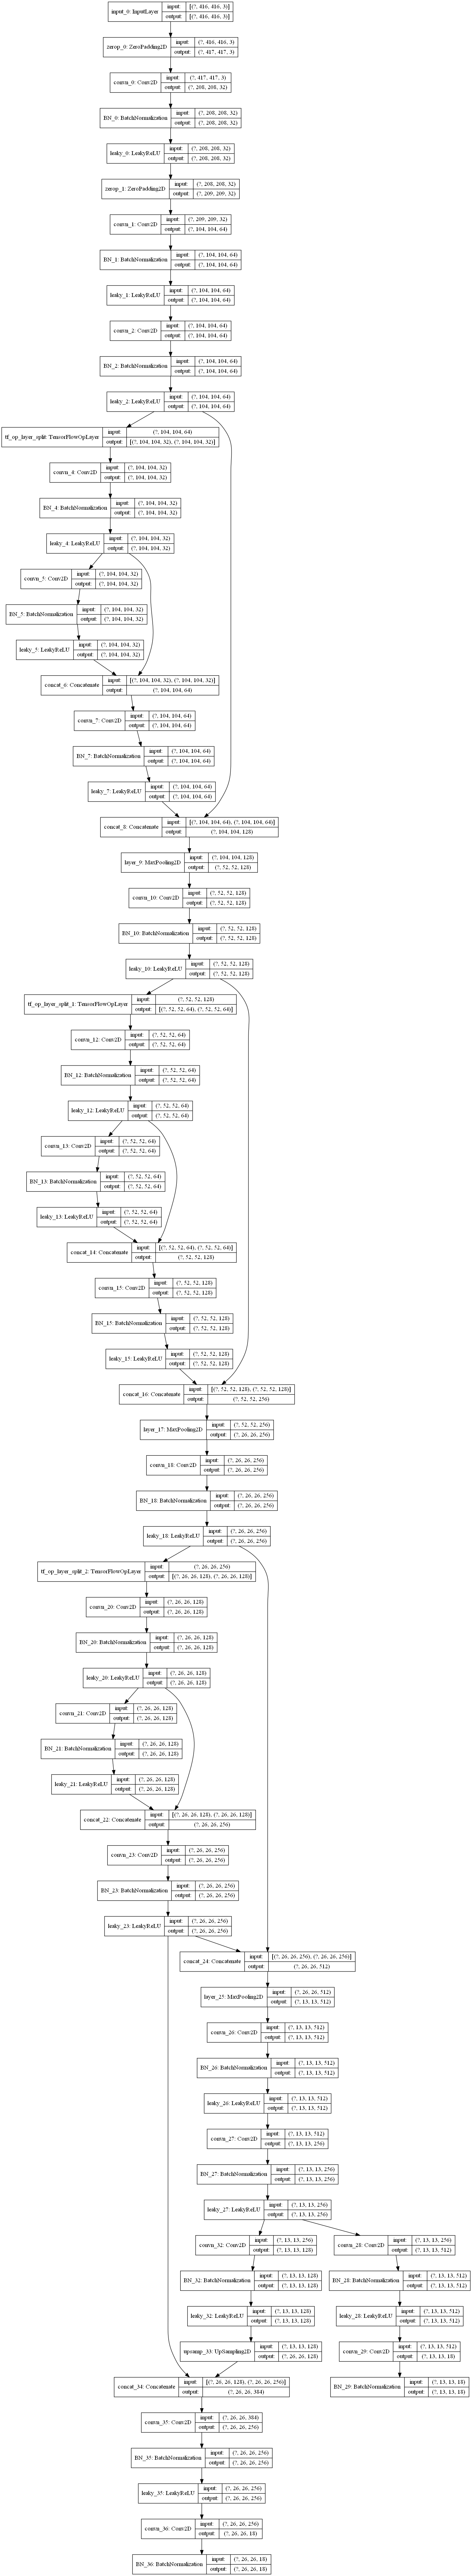

In [6]:
tf.keras.utils.plot_model( model, show_shapes=True)

In [7]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(37):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [29, 36]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0

In [8]:
# Get and compute the weights
weight_reader = WeightReader('grayscale_43.weights')
weight_reader.load_weights(model)

reading 64 bytes
loading weights of convolution #0- nb parameters: 896
loading weights of convolution #1- nb parameters: 18496
loading weights of convolution #2- nb parameters: 36928
no convolution #3
loading weights of convolution #4- nb parameters: 9248
loading weights of convolution #5- nb parameters: 9248
no convolution #6
loading weights of convolution #7- nb parameters: 4160
no convolution #8
no convolution #9
loading weights of convolution #10- nb parameters: 147584
no convolution #11
loading weights of convolution #12- nb parameters: 36928
loading weights of convolution #13- nb parameters: 36928
no convolution #14
loading weights of convolution #15- nb parameters: 16512
no convolution #16
no convolution #17
loading weights of convolution #18- nb parameters: 590080
no convolution #19
loading weights of convolution #20- nb parameters: 147584
loading weights of convolution #21- nb parameters: 147584
no convolution #22
loading weights of convolution #23- nb parameters: 65792
no con

In [9]:
# Save the model
model.save('saved_model/model_grayscale43')
model.save('models/yolo/grayscale43.h5')
! dir models\yolo\*.h5

Der Befehl "rm" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/model_grayscale43\assets
 Datentr„ger in Laufwerk C: ist NVME
 Volumeseriennummer: 8047-3A2D

 Verzeichnis von C:\Users\schro\Downloads\Yolov-4-master\models\yolo

24.03.2021  02:21        23.741.912 grayscale.h5
24.03.2021  19:59        23.741.912 grayscale2.h5
03.04.2021  10:10        23.743.296 grayscale43.h5
13.03.2021  22:36        23.743.296 yolov4.h5
18.03.2021  21:20        23.770.928 yolov4_2.h5
18.03.2021  23:14        23.770.928 yolov4_3.h5
               6 Datei(en),    142.512.272 Bytes
               0 Verzeichnis(se), 344.810.807.296 Bytes frei


In [10]:
#Convort to Tflite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/model_grayscale43')
tflite_model = converter.convert()
with open('grayscale43.tflite', 'wb') as f:
  f.write(tflite_model)